<a href="https://colab.research.google.com/github/mortgad/DLVR/blob/main/UTKface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Loading the data

In [2]:
!pip install PyDrive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.4/987.4 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PyDrive: filename=PyDrive-1.3.1-py3-none-any.whl size=27433 sha256=ffb940a8759a6d33e9978f7d3f9e7c0784fef9a4b3a6742de39d33ab1221b6c5
  Stored in directory: /root/.cache/pip/wheels/63/79/df/924c22c080c9dac1a57f611baa837fe0bc3daec1500b27f23b
Successfully built PyDrive


In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import tarfile

# Authenticate PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Folder ID from the shared Google Drive folder
folder_id = '1HROmgviy4jUUUaCdvvrQ8PcqtNg2jn3G'
file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

# Loop through the files and download each .tar.gz file
for file in file_list:
    if file['title'].endswith('.tar.gz'):
        print(f'Downloading {file["title"]}')
        file.GetContentFile(file['title'])

        # Extract the .tar.gz file
        tar = tarfile.open(file['title'])
        tar.extractall('/content/extracted')  # Extract all files to /content/extracted directory
        tar.close()

        print(f'Extracted {file["title"]}')

Extracted part3.tar.gz
Extracted part2.tar.gz
Extracted part1.tar.gz


# 2. Data Preprocessing

## Data test

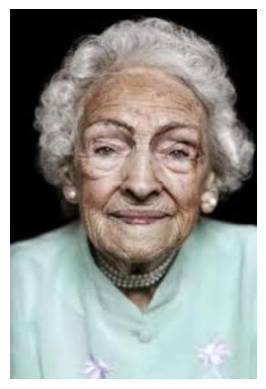

Shape: (551, 368, 3)


In [4]:
import cv2
import matplotlib.pyplot as plt

file_path = '/content/extracted/part3/100_1_0_20170119212053665.jpg'
image = cv2.imread(file_path)

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()

# Print the shape of the image
print(f"Shape: {image.shape}")


## Delete non-images

In [5]:
import os

def delete_non_image_files(directories, allowed_extensions=('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
    for directory in directories:
        for filename in os.listdir(directory):
            if not filename.lower().endswith(allowed_extensions):
                file_path = os.path.join(directory, filename)
                os.remove(file_path)
                print(f"Deleted: {file_path}")

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

# Run the function to delete non-image files
delete_non_image_files(directories)

Deleted: /content/extracted/part3/.DS_Store
Deleted: /content/extracted/part3/44_1_4_20170116235150272.pg
Deleted: /content/extracted/part3/55_0_0_20170116232725357jpg


## Delete invalid mesasges

In [6]:
import os
import re

def delete_invalid_images(directories):
    # Regular expression pattern to match the desired format
    pattern = re.compile(r'^\d+_\d+_\d+_\d+\.\w+$')

    for directory in directories:
        for filename in os.listdir(directory):
            # Check if the filename matches the desired pattern
            if not pattern.match(filename):
                file_path = os.path.join(directory, filename)
                os.remove(file_path)
                print(f"Deleted: {file_path}")

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

# Run the function to delete invalid images
delete_invalid_images(directories)

Deleted: /content/extracted/part1/61_3_20170109150557335.jpg
Deleted: /content/extracted/part1/61_1_20170109142408075.jpg
Deleted: /content/extracted/part2/39_1_20170116174525125.jpg
Deleted: /content/extracted/part2/53__0_20170116184028385.jpg
Deleted: /content/extracted/part3/24_0_1_20170116220224657 .jpg


## Resizing images
- Adjust target size when experimenting
- MobileNet V3 size: (224,224,3)

In [7]:
import cv2
import os

target_size = (224,224)

def resize_images_in_directories(directories, target_size):
    supported_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

    for directory in directories:
        for filename in os.listdir(directory):
            if filename.lower().endswith(supported_extensions):
                file_path = os.path.join(directory, filename)

                # Read the image
                image = cv2.imread(file_path)

                if image is not None:
                    # Resize the image to the target size
                    resized_image = cv2.resize(image, target_size)

                    # Save the resized image back to the same path, or specify a different path if needed
                    cv2.imwrite(file_path, resized_image)
                else:
                    print(f"Warning: Failed to load {file_path}, skipping.")
            else:
                print(f"Skipping non-image file: {filename}")

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

resize_images_in_directories(directories, target_size)

## Creating lists for training

In [8]:
import os
import cv2
import numpy as np
import pandas as pd

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

# Process each directory
i = 1  # Moved this outside the loop to avoid resetting
# Initialize lists to store images and labels
images = []
ages = []
genders = []
ethnicities = []

for directory in directories:
    print(f"Processing from: {directory}")
    files = os.listdir(directory)

    for file in files:
        file_path = os.path.join(directory, file)

        # Read the image
        image = cv2.imread(file_path)

        if image is not None:  # Check if the image was loaded successfully
            # Convert BGR to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Append the flattened image and labels to their respective lists
            images.append(image_rgb)
            split_var = file.split('_')
            ages.append(int(split_var[0]))
            genders.append(int(split_var[1]))
            ethnicities.append(int(split_var[2]))
        else:
            print(f"Failed to load image: {file_path}")

    i += 1  # Increment the counter

Processing from: /content/extracted/part1
Processing from: /content/extracted/part2
Processing from: /content/extracted/part3


In [9]:
# After processing each directory, you can print the lengths of your lists:
print(f"Length of ages: {len(ages)}")
print(f"Length of genders: {len(genders)}")
print(f"Length of ethnicities: {len(ethnicities)}")
print(f"Length of images: {len(images)}")

# Convert your labels to numpy arrays
ages = np.array(ages)
genders = np.array(genders)
ethnicities = np.array(ethnicities)
images = np.array(images)

Length of ages: 24101
Length of genders: 24101
Length of ethnicities: 24101
Length of images: 24101


# 3. EDA

In [14]:
# Get libraries for loading data and plotting subgroups

import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np


# Make one dataframe with all lists:
# Creating DataFrame
df = pd.DataFrame({
    'Age': ages,
    'Gender': genders,
    'Ethnicity': ethnicities
})

df.head(5)

,Age,Gender,Ethnicity
0,36,1,0
1,14,0,0
2,49,0,0
3,25,1,2
4,1,0,3


In [15]:
# Looking at simple descriptive statistic, which may only be releveant for the numeric collumn age
df.describe()

# We see that there are age from 1 - 116. It could be discussed whehter pictures of babies are needed to build this model.
# I should maybe also discuss whether 116 is an outlier.

,Age,Gender,Ethnicity
count,24101.000000,24101.000000,24101.000000
mean,33.042156,0.478030,1.271731
std,20.139284,0.499527,1.343888
min,1.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000
50%,29.000000,0.000000,1.000000
75%,45.000000,1.000000,2.000000
max,116.000000,1.000000,4.000000


<Axes: xlabel='Ethnicity', ylabel='count'>

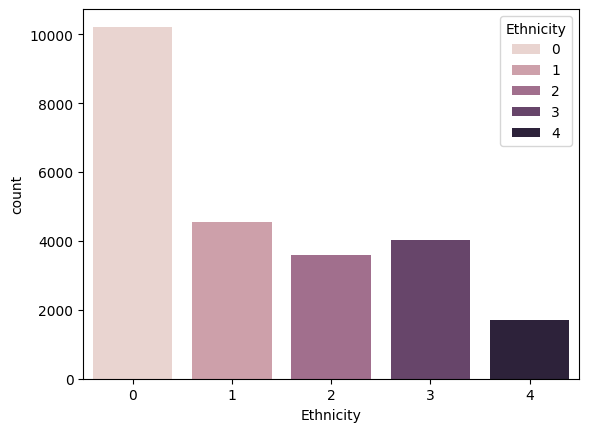

In [16]:
# Look at the categorical variables.

# First Ethnicity
sns.countplot(data=df, x ='Ethnicity', hue ='Ethnicity')

# There are way more white people than any other Ethnicity

<Axes: xlabel='Gender', ylabel='count'>

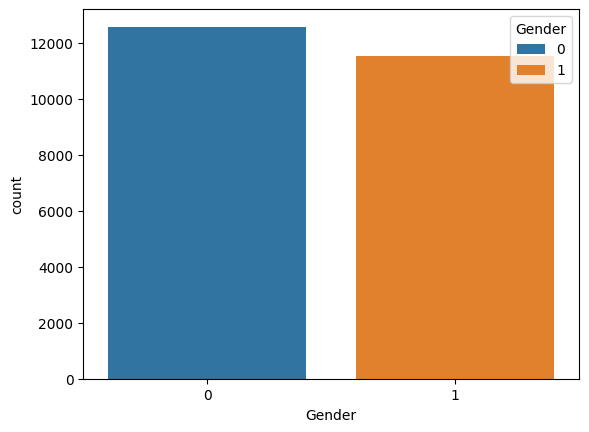

In [17]:
# Then gender distribution is almost perfectly 50/50
sns.countplot(data=df, x ='Gender', hue ='Gender')

<Axes: xlabel='Age', ylabel='Density'>

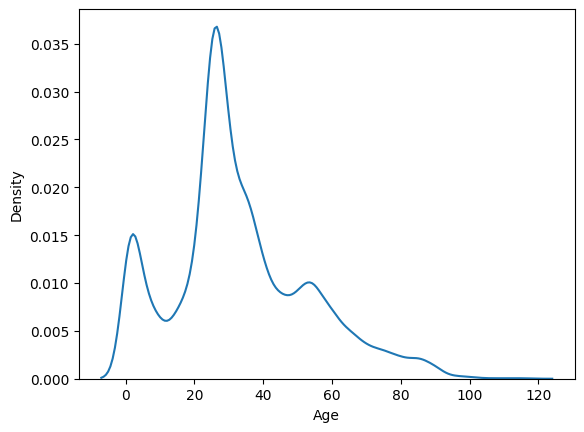

In [18]:
# Plot of the age for all observations:
sns.kdeplot(data=df, x='Age')

# It may be a bit problematic, there is only a few of the observations which is around the threshold
# between 15-20 which is where we will have our cut off.

<Axes: xlabel='Age', ylabel='Density'>

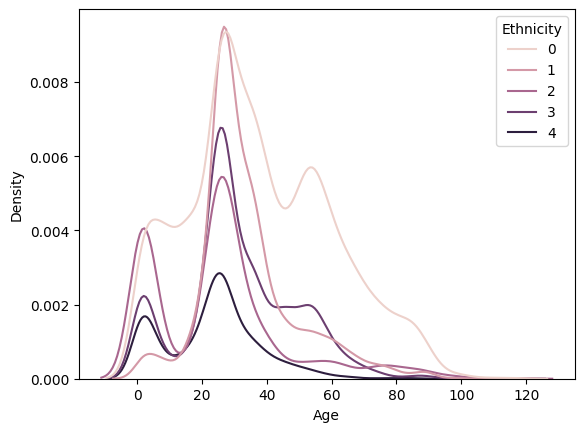

In [19]:
# Plot age for the etnicity to tell if it is the same acroos all etnicities
sns.kdeplot(data=df, x='Age', hue='Ethnicity')

# We see that the distribution of age throughout the classes are almost the same with the exeption
# of 0 which have more peoepl between 15-20 as well as 60-65

# 5. Baseline MobileNet v3

## Sparse encoding target

In [10]:
# Convert all values in the ages list to integers
ages_int = [int(age) for age in ages]

# Convert the ages to a DataFrame
ages_df = pd.DataFrame(ages_int, columns=['age'])

bins = [0, 9, 18, 27, 36, 45, 54, 63, 72, 81, float('inf')]
labels = ['0-9', '9-18', '18-27', '27-36', '36-45', '45-54', '54-63', '63-72', '72-81', '81+']

# Create age groups with integer labels
ages_df['age_group'] = pd.cut(ages_df['age'], bins=bins, labels=False, right=False)

# Example output
print(f"Age groups (as sparse integers):\n{ages_df['age_group'].head()}")

num_classes = len(bins) - 1
print(f"Number of classes: {num_classes}")

Age groups (as sparse integers):
0    4
1    1
2    5
3    2
4    0
Name: age_group, dtype: int64
Number of classes: 10


## Model setup for train

In [11]:
from keras.applications.mobilenet_v3 import preprocess_input  # Update the import for MobileNet
import keras
from keras import layers, models  # Import the required modules

# Preprocess your images using the MobileNet preprocessing
images_preprocessed = preprocess_input(images)

# Now proceed with the MobileNet model using the preprocessed images
conv_base = keras.applications.MobileNetV3Large(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

# Getting training and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images_preprocessed,
                                                    ages_df['age_group'],
                                                    test_size=0.2,
                                                    shuffle  = True)

12683000/12683000 [==============================] - 0s 0us/step


In [12]:
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               492032    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328

In [13]:
# Set custom learning rate for RMSProp optimizer
learning_rate = 1e-3  # Adjust as needed
optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint

file_path = '/content/drive/MyDrive/DL for VR/Project/Models/'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + 'best_mobilenet_model_baseline.keras',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

## Train model

In [15]:
mobilenet_history = model.fit(
    x_train,
    y_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint]
)

Epoch 1/30
603/603 [==============================] - ETA: 0s - loss: 1.6100 - accuracy: 0.3884
Epoch 1: val_accuracy improved from -inf to 0.43373, saving model to /content/drive/MyDrive/DL for VR/Project/Models/best_mobilenet_model_baseline.keras
603/603 [==============================] - 110s 175ms/step - loss: 1.6100 - accuracy: 0.3884 - val_loss: 1.4243 - val_accuracy: 0.4337
Epoch 2/30
603/603 [==============================] - ETA: 0s - loss: 1.4504 - accuracy: 0.4341
Epoch 2: val_accuracy improved from 0.43373 to 0.45488, saving model to /content/drive/MyDrive/DL for VR/Project/Models/best_mobilenet_model_baseline.keras
603/603 [==============================] - 101s 168ms/step - loss: 1.4504 - accuracy: 0.4341 - val_loss: 1.3922 - val_accuracy: 0.4549
Epoch 3/30
603/603 [==============================] - ETA: 0s - loss: 1.4132 - accuracy: 0.4506
Epoch 3: val_accuracy improved from 0.45488 to 0.45841, saving model to /content/drive/MyDrive/DL for VR/Project/Models/best_mobilene

## Evaluating the model

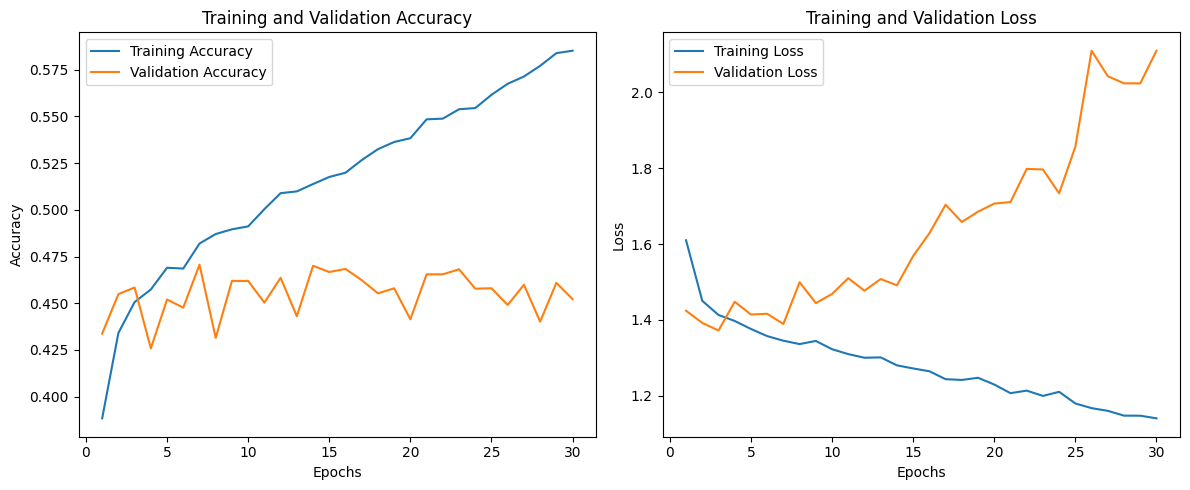

In [16]:
import matplotlib.pyplot as plt

# Get the accuracy and loss data from the history object
accuracy = mobilenet_history.history['accuracy']
val_accuracy = mobilenet_history.history['val_accuracy']
loss = mobilenet_history.history['loss']
val_loss = mobilenet_history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

151/151 [==============================] - 22s 136ms/step


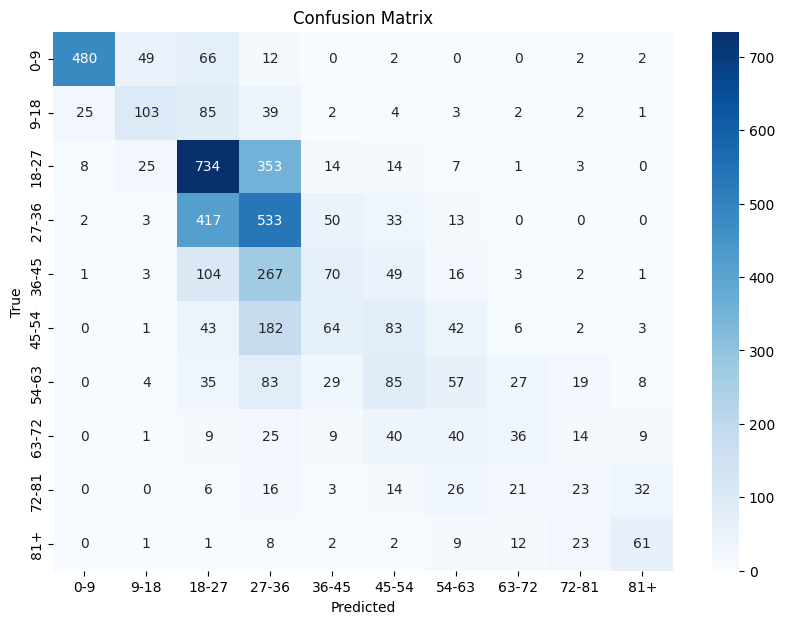

In [17]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Replace with actual model prediction logic, e.g., from a Keras or Scikit-learn model
# Example (for Keras): Assuming you have one-hot encoded predictions
y_pred = model.predict(x_test)  # x_test is your test data
y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot to sparse integer predictions

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Assuming you have already obtained y_pred from your model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot to integer predictions

# Loop through genders and ethnicities to get confusion matrices and accuracy for each group
unique_genders = np.unique(genders)
unique_ethnicities = np.unique(ethnicities)

for gender in unique_genders:
    for ethnicity in unique_ethnicities:
        # Filter predictions and true labels by gender and ethnicity
        idx = (genders == gender) & (ethnicities == ethnicity)
        y_test_filtered = y_test[idx]
        y_pred_filtered = y_pred[idx]

        # Compute confusion matrix and accuracy for the filtered subset
        cm = confusion_matrix(y_test_filtered, y_pred_filtered)
        accuracy = accuracy_score(y_test_filtered, y_pred_filtered)

        print(f'Confusion Matrix for Gender {gender} and Ethnicity {ethnicity}:')
        print(cm)
        print(f'Accuracy for Gender {gender} and Ethnicity {ethnicity}: {accuracy:.2f}')

        # Optionally, you can plot the confusion matrix as well
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix for Gender {gender} and Ethnicity {ethnicity}')
        plt.show()


151/151 [==============================] - 20s 132ms/step


IndexError: Boolean index has wrong length: 24101 instead of 4821

In [ ]:
for gender in unique_genders:
    for ethnicity in unique_ethnicities:
        idx = (genders == gender) & (ethnicities == ethnicity)
        y_test_filtered = y_test[idx]
        y_pred_filtered = y_pred[idx]

        print(f'Classification Report for Gender {gender} and Ethnicity {ethnicity}:')
        print(classification_report(y_test_filtered, y_pred_filtered, target_names=labels))


# 6. Motivated experiments